# Perceptron Convergence Theorem — Numerical Illustration

This notebook illustrates Rosenblatt's perceptron convergence theorem in a simple two–dimensional setting.

We will:

1. Construct a **linearly separable** dataset and train a perceptron.
2. Track the quantities that appear in the classical convergence proof:
   - The inner product between the current weight vector $w_t$ and a fixed separating vector $w^*$.
   - The norm $\lVert w_t \rVert$.
3. Compare the empirical number of updates with the theoretical bound $ (R/\gamma)^2 $, where
   - $R = \max_i \lVert x_i \rVert$,
   - $\gamma = \min_i y_i (w^* \cdot x_i + b^*)$ is a margin for a separating hyperplane $(w^*, b^*)$.
4. Show a simple **non-separable** example (XOR-type dataset) where the perceptron does **not** converge (it keeps making mistakes if we let it run forever).

---

> **Important assumption in the theorem:**  
> The perceptron convergence theorem only guarantees convergence if there *exists* a hyperplane that strictly separates the two classes.  
> A generic random dataset in $\mathbb{R}^d$ will not necessarily be linearly separable.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Make plots appear in the notebook
%matplotlib inline

## 1. Linearly separable data

We generate synthetic data using a *hidden* separating hyperplane $(w^*, b^*)$ with a positive margin.
We then sample points and label them by the sign of $w^* \cdot x + b^*$, rejecting points that lie too close
to the boundary to keep a reasonably large margin.

X shape: (60, 2)
Number of +1 labels: 34
Number of -1 labels: 26


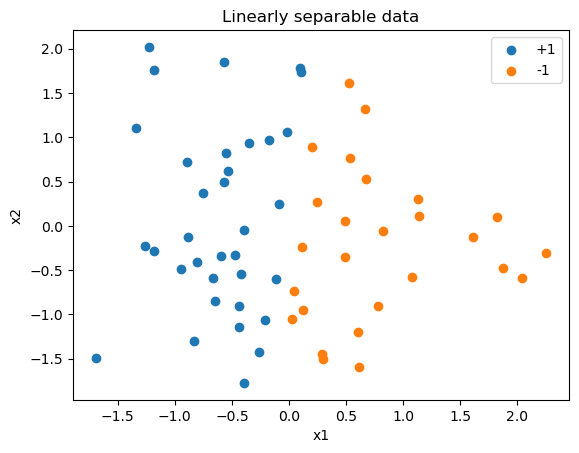

In [2]:
def generate_separable_data(n_samples=60, dim=2, margin=0.005, random_state=127):
    rng = np.random.RandomState(random_state)
    w_star = rng.randn(dim)
    w_star = w_star / np.linalg.norm(w_star)
    b_star = rng.randn() * 0.1  # small random bias

    X = []
    y = []
    while len(X) < n_samples:
        x = rng.randn(dim)
        m = w_star @ x + b_star
        if abs(m) < margin:
            # too close to the boundary, skip to maintain a margin
            continue
        label = 1 if m > 0 else -1
        X.append(x)
        y.append(label)

    X = np.array(X)
    y = np.array(y)

    return X, y, w_star, b_star

X, y, w_star, b_star = generate_separable_data()

print("X shape:", X.shape)
print("Number of +1 labels:", np.sum(y == 1))
print("Number of -1 labels:", np.sum(y == -1))

# Quick scatter plot of the data
plt.figure()
plt.scatter(X[y == 1, 0], X[y == 1, 1], label="+1")
plt.scatter(X[y == -1, 0], X[y == -1, 1], label="-1")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.title("Linearly separable data")
plt.show()

## 2. Perceptron algorithm and tracking of proof quantities

We implement the standard perceptron update rule for labels $y_i \in \{-1, +1\}$:

$$
\text{If } y_i (w \cdot x_i + b) \le 0,\quad
w \leftarrow w + y_i x_i, \quad b \leftarrow b + y_i.
$$

During training we track, after each *update*:

- $w_t \cdot w^*$
- $\lVert w_t \rVert^2$

and we also count the total number of updates.

Final weights: [-5.64163572  1.02833811]
Final bias: 0.0
Total number of updates: 24
Number of epochs run: 5


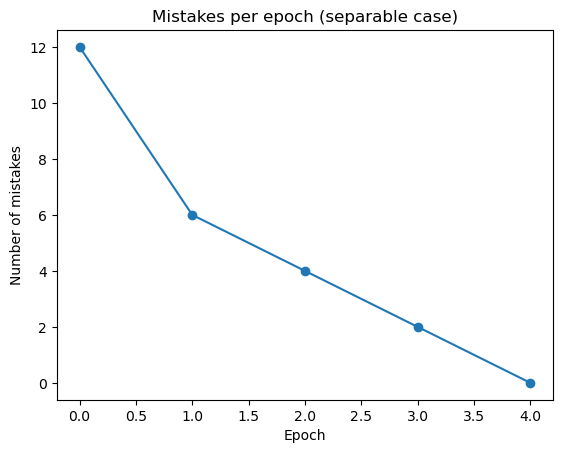

In [3]:
def perceptron_train(X, y, max_epochs=1000, w_star=None, b_star=None):
    n_samples, dim = X.shape
    w = np.zeros(dim)
    b = 0.0

    history = {
        "w": [],
        "b": [],
        "update_index": [],
        "w_dot_wstar": [],
        "w_norm_sq": [],
        "mistakes_per_epoch": []
    }

    total_updates = 0

    for epoch in range(max_epochs):
        mistakes = 0
        for i in range(n_samples):
            if y[i] * (w @ X[i] + b) <= 0:
                # misclassified, perform update
                w = w + y[i] * X[i]
                b = b + y[i]
                mistakes += 1
                total_updates += 1
                
                history["update_index"].append(i)

                if w_star is not None:
                    history["w_dot_wstar"].append(w @ w_star)
                else:
                    history["w_dot_wstar"].append(None)
                history["w_norm_sq"].append(np.dot(w, w))

                history["w"].append(w.copy())
                history["b"].append(b)

        history["mistakes_per_epoch"].append(mistakes)

        if mistakes == 0:
            break

    return w, b, history, total_updates

w, b, history, total_updates = perceptron_train(X, y, max_epochs=100, w_star=w_star, b_star=b_star)

print("Final weights:", w)
print("Final bias:", b)
print("Total number of updates:", total_updates)
print("Number of epochs run:", len(history['mistakes_per_epoch']))

plt.figure()
plt.plot(history["mistakes_per_epoch"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Number of mistakes")
plt.title("Mistakes per epoch (separable case)")
plt.show()

## 3. Visualizing the learned decision boundary

In $\mathbb{R}^2$ the perceptron defines a line

$$
\{x \in \mathbb{R}^2 : w \cdot x + b = 0\}.
$$

We plot this line together with the training points.

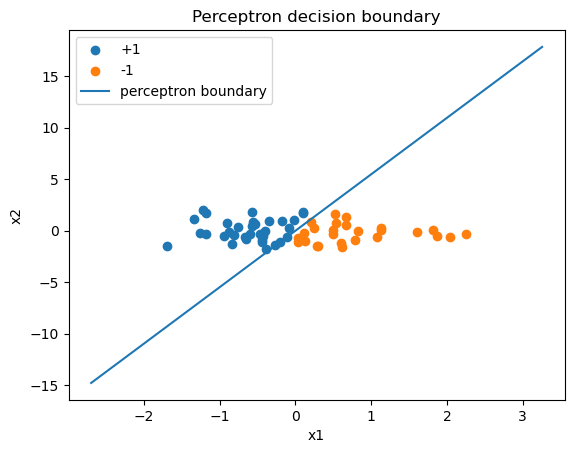

In [4]:
def plot_decision_boundary(w, b, X, y):
    plt.figure()
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="+1")
    plt.scatter(X[y == -1, 0], X[y == -1, 1], label="-1")

    if w[1] != 0:
        x_vals = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
        y_vals = -(w[0] * x_vals + b) / w[1]
        plt.plot(x_vals, y_vals, label="perceptron boundary")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.title("Perceptron decision boundary")
    plt.show()

plot_decision_boundary(w, b, X, y)

## 4. Connecting to the convergence proof

The classical proof assumes that there exists a separating hyperplane $(w^*, b^*)$ such that

$$
y_i (w^* \cdot x_i + b^*) \ge \gamma > 0 \quad \text{for all } i
$$

and that

$$
\lVert x_i \rVert \le R \quad \text{for all } i.
$$

It then shows that the perceptron makes at most $ (R/\gamma)^2 $ updates.

Here we estimate empirical values of $R$ and $\gamma$ using our *hidden* separating hyperplane $(w^*, b^*)$
and compare this bound with the observed number of updates.

In [5]:
# Compute R and gamma for our synthetic data and the "teacher" hyperplane (w_star, b_star)
norms = np.linalg.norm(X, axis=1)
R = norms.max()
margins = y * (X @ w_star + b_star)
gamma = margins.min()

print("R (max ||x_i||):", R)
print("gamma (margin):", gamma)
if gamma > 0:
    bound = (R / gamma) ** 2
    print("Theoretical upper bound on number of updates (R/gamma)^2:", bound)
else:
    print("Warning: gamma <= 0, data not strictly separable by (w*, b*).")

print("Observed number of updates:", total_updates)

R (max ||x_i||): 2.362417682785382
gamma (margin): 0.021124601725237092
Theoretical upper bound on number of updates (R/gamma)^2: 12506.515047942165
Observed number of updates: 24


### Evolution of $w_t \cdot w^*$ and $\lVert w_t \rVert^2$

A key part of the proof is to show that:

1. $w_{t+1} \cdot w^* \ge w_t \cdot w^* + \gamma$ (it grows at least linearly with the number of mistakes), and
2. $\lVert w_{t+1} \rVert^2 \le \lVert w_t \rVert^2 + R^2$ (it grows at most linearly with the number of mistakes).

Together, these imply a contradiction if the number of updates exceeds $ (R/\gamma)^2 $.

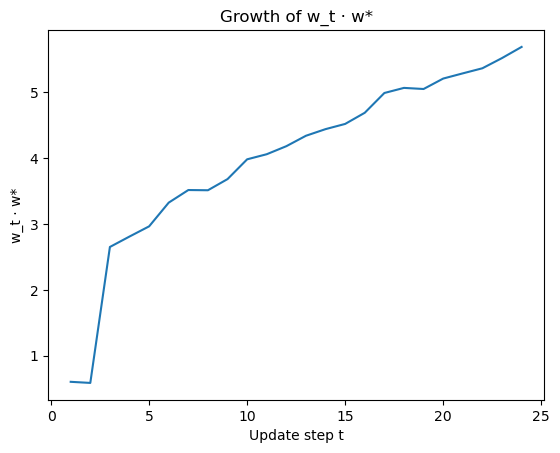

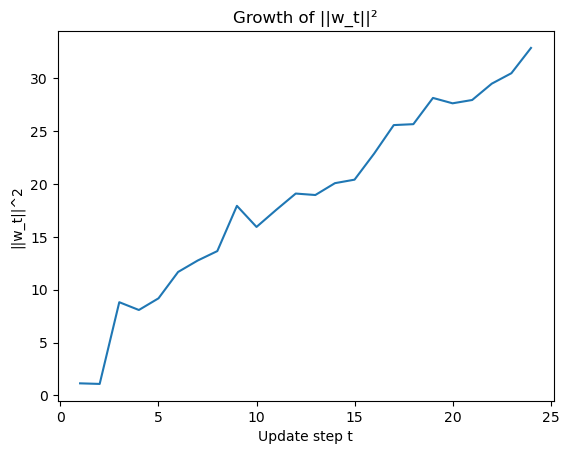

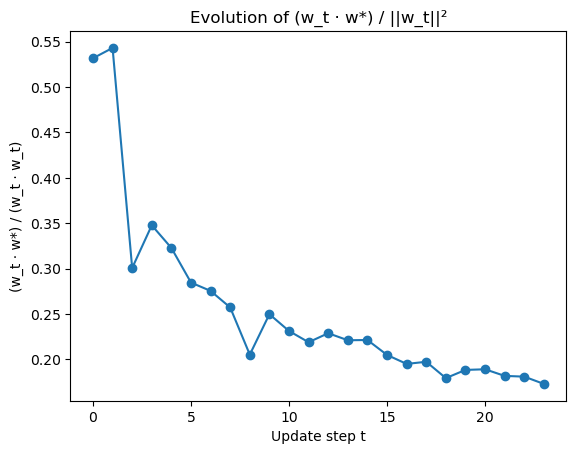

In [6]:
# Convert history to arrays
w_hist = np.array(history["w"])             # shape: (T, 2)
w_dot_wstar = np.array([v for v in history["w_dot_wstar"] if v is not None])
w_norm_sq = np.array(history["w_norm_sq"])

steps = np.arange(1, len(w_norm_sq) + 1)

plt.figure()
plt.plot(steps, w_dot_wstar)
plt.xlabel("Update step t")
plt.ylabel("w_t · w*")
plt.title("Growth of w_t · w*")
plt.show()

plt.figure()
plt.plot(steps, w_norm_sq)
plt.xlabel("Update step t")
plt.ylabel("||w_t||^2")
plt.title("Growth of ||w_t||²")
plt.show()

# Avoid division by zero
ratio = w_dot_wstar / w_norm_sq

plt.figure()
plt.plot(ratio, marker="o")
plt.xlabel("Update step t")
plt.ylabel("(w_t · w*) / (w_t · w_t)")
plt.title("Evolution of (w_t · w*) / ||w_t||²")
plt.show()

In [16]:
w_hist = history["w"]
b_hist = history["b"]
update_index = history["update_index"]

# Set up the figure and base scatter of the data
fig, ax = plt.subplots()

ax.scatter(X[y == 1, 0], X[y == 1, 1], label="+1")
ax.scatter(X[y == -1, 0], X[y == -1, 1], label="-1")

# Fix axis limits so they don't jump during animation
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal', adjustable='box')

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.legend()

# Line object for the decision boundary
(line,) = ax.plot([], [])
# Highlight point used for the current update (if we know it)
highlight, = ax.plot([], [], 'o', markersize=10, color="red", zorder=0, label="updated point")

# Quiver for the normal vector (w_t) from the origin
q = ax.quiver(0, 0, 0, 0, angles="xy", scale_units="xy", scale=1)

def init():
    line.set_data([], [])
    highlight.set_data([], [])
    q.set_UVC(0, 0)
    ax.set_title("Perceptron updates")
    return line, q, highlight

def update(frame):
    w = w_hist[frame]
    b = b_hist[frame]

    # Compute decision boundary line
    x_vals = np.linspace(x_min, x_max, 200)

    if w[1] != 0:
        y_vals = -(w[0] * x_vals + b) / w[1]
    else:
        # Vertical line: x = -b / w[0]
        x_vals = np.full_like(x_vals, -b / w[0])
        y_vals = np.linspace(y_min, y_max, 200)

    line.set_data(x_vals, y_vals)

    # Highlight the point that caused this update, if we stored indices
    if update_index is not None:
        idx = update_index[frame]
        x_mis = X[idx]
        highlight.set_data([x_mis[0]], [x_mis[1]])
    else:
        highlight.set_data([], [])

    # Ratio (w_t · w*) / (w_t · w_t)
    wt_dot_wstar = w @ w_star
    wt_norm_sq = w @ w
    ratio = wt_dot_wstar / wt_norm_sq

    # Scaled normal vector v_t = ratio * w_t
    w_norm = np.linalg.norm(w)
    v = ratio * (w / w_norm)

    q.set_UVC(v[0], v[1])
    ax.set_title(f"Step {frame + 1}, ratio = {ratio:.3f}")

    return line, q

ani = FuncAnimation(
    fig,
    update,
    frames=len(w_hist),
    init_func=init,
    blit=True,
    interval=200,  # ms between frames
)

plt.close(fig)  # avoid double static figure in some Jupyter setups

HTML(ani.to_jshtml())


## 5. Non-separable data (XOR example)

To emphasize that the convergence theorem **requires** linear separability, we now construct a simple non-separable
dataset in $\mathbb{R}^2$: an XOR pattern.

No hyperplane can separate the positive and negative points here, and the perceptron will keep making mistakes
indefinitely (we just stop it after a fixed number of epochs).

XOR-like dataset in 2D

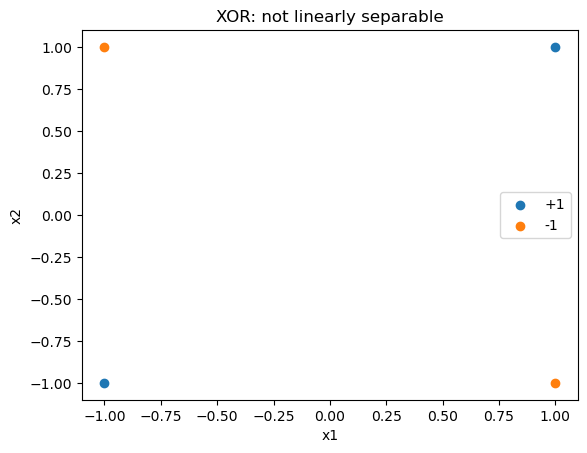

In [8]:
X_xor = np.array([[1, 1],
                  [1, -1],
                  [-1, 1],
                  [-1, -1]], dtype=float)
y_xor = np.array([1, -1, -1, 1])  # XOR labels

plt.figure()
plt.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1], label="+1")
plt.scatter(X_xor[y_xor == -1, 0], X_xor[y_xor == -1, 1], label="-1")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("XOR: not linearly separable")
plt.legend()
plt.show()

In [9]:
w_xor, b_xor, history_xor, total_updates_xor = perceptron_train(X_xor, y_xor, max_epochs=50)

print("Total updates (non-separable, capped at 50 epochs):", total_updates_xor)
print("Mistakes per epoch:", history_xor["mistakes_per_epoch"])

Total updates (non-separable, capped at 50 epochs): 200
Mistakes per epoch: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


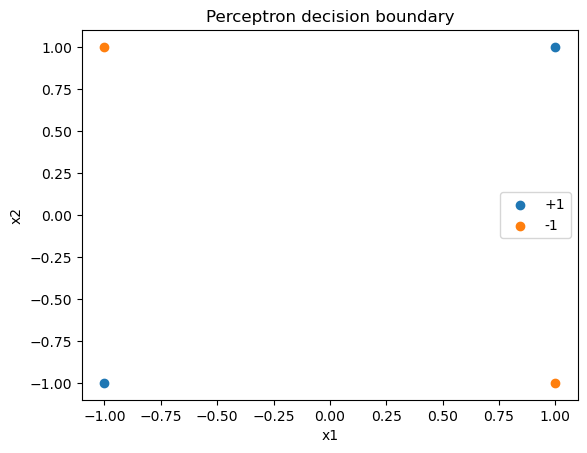

In [10]:
plot_decision_boundary(w_xor, b_xor, X_xor, y_xor)

You should see that the perceptron continues to make mistakes in many epochs and does not find
a perfect separating hyperplane — consistent with the fact that no such hyperplane exists for the XOR dataset.

This illustrates the key point of Rosenblatt's perceptron convergence theorem:

> **Convergence is guaranteed only under the assumption of strict linear separability.**

For a generic random dataset, this assumption will *not* automatically hold, so the perceptron may fail to converge.